In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIRv2_0 import *
import scipy as sp
import pickle
import time

In [2]:
emission_input = pd.read_pickle('./Sample_data/best_estimate_emissions.pkl')

otherforc = return_empty_forcing(emission_input.index[0],emission_input.index[-1],scen_names=emission_input.columns.levels[0])

RCP_forcing = pd.read_csv('/home/nleach/Documents/UnFaIR v2/UnFaIRv2.0/Sample_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

otherforc.loc[:,('best_estimate','forcing')] = (RCP_forcing['TOTAL_INCLVOLCANIC_RF'] - RCP_forcing['CO2CH4N2O_RF']).loc[:2012]

gas_params = default_gas_forcing_params()

thermal_params = default_thermal_params()

gas_uncert = default_gas_forcing_param_uncertainty()

thermal_uncert = default_thermal_param_uncertainty()

gas_param_set = draw_monte_carlo_param_set(200,gas_params,gas_uncert,type='normal')

thermal_param_set = draw_monte_carlo_param_set(200,thermal_params,thermal_uncert,type='lognormal')

starttime=time.time()
model_output = run_UnFaIR(emission_input,otherforc,gas_parameters=gas_param_set,thermal_parameters=thermal_param_set)
print(time.time()-starttime)

Integrating 1 scenarios, 200 gas cycle parameter sets, 200 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1765 and 2012...
35.39365077018738


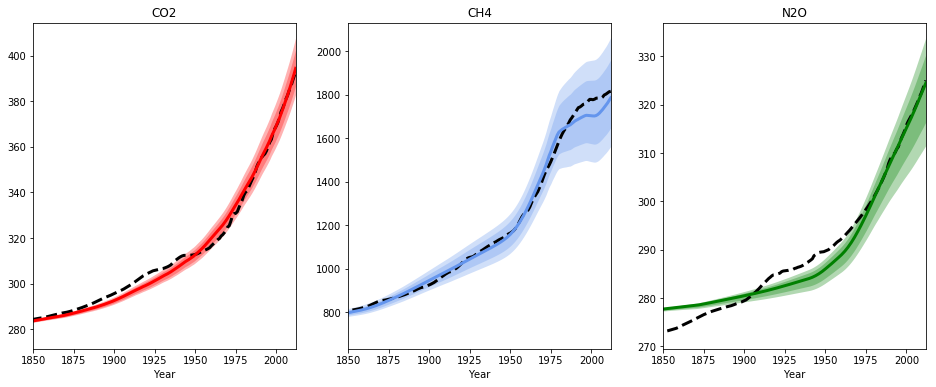

In [3]:
cmip6_concs = pd.read_csv('/home/nleach/Documents/UnFaIR/5eqSCM/Nick_UnFaIR/CMIP_input_ems/Supplementary_Table_UoM_GHGConcentrations-1-1-0_annualmeans_v23March2017.csv',skiprows=21,index_col=0)

fig,ax=plt.subplots(1,3,figsize=(16,6))

colors = {'CO2':'r','CH4':'cornflowerblue','N2O':'g'}

for i,s in enumerate(['CO2','CH4','N2O']):
    ax[i].fill_between(model_output['C'].index,model_output['C'].xs(s,level=-1,axis=1).quantile(0.05,axis=1),model_output['C'].xs(s,level=-1,axis=1).quantile(0.95,axis=1),color=colors[s],alpha=0.3,linewidth=0)
    ax[i].fill_between(model_output['C'].index,model_output['C'].xs(s,level=-1,axis=1).quantile(0.16,axis=1),model_output['C'].xs(s,level=-1,axis=1).quantile(0.84,axis=1),color=colors[s],alpha=0.3,linewidth=0)
    model_output['C'].xs(s,level=-1,axis=1).median(axis=1).plot(ax=ax[i],legend=None,color=colors[s],linewidth=3,linestyle='-')
    ax[i].plot(cmip6_concs.loc[1765:2012,s],'k--',zorder=1,linewidth=3)
    ax[i].set_xlim(1850,2012)
    ax[i].set_title(s)

In [4]:
IAMC_db = pd.read_csv('./Sample_data/IAMC_T_RF_E_C.csv')

IAMC_db['ModScen'] = IAMC_db['Model'] + IAMC_db['Scenario']

IAMC_db['Variable'].unique()

array(['Emissions|CH4', 'Emissions|CO2', 'Emissions|N2O',
       'AR5 climate diagnostics|Temperature|Global Mean|FAIR|Expected value',
       'AR5 climate diagnostics|Temperature|Global Mean|FAIR|MED',
       'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|Expected value',
       'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED',
       'Concentration|CH4', 'Concentration|CO2', 'Concentration|N2O',
       'Forcing', 'Forcing|CH4', 'Forcing|CO2', 'Forcing|N2O',
       'Temperature|Global Mean', nan], dtype=object)

In [5]:
CO2Eset = set(IAMC_db.loc[IAMC_db['Variable']=='Emissions|CO2','ModScen'])
CH4Eset = set(IAMC_db.loc[IAMC_db['Variable']=='Emissions|CH4','ModScen'])
N2OEset = set(IAMC_db.loc[IAMC_db['Variable']=='Emissions|N2O','ModScen'])
Fset = set(IAMC_db.loc[IAMC_db['Variable']=='Forcing','ModScen'])
CO2Fset = set(IAMC_db.loc[IAMC_db['Variable']=='Forcing|CO2','ModScen'])
CH4Fset = set(IAMC_db.loc[IAMC_db['Variable']=='Forcing|CH4','ModScen'])
N2OFset = set(IAMC_db.loc[IAMC_db['Variable']=='Forcing|N2O','ModScen'])

common_models = CO2Eset.intersection(CH4Eset,N2OEset,Fset,CO2Fset,CH4Fset,N2OFset)

In [6]:
# This box has some FaNcY Indexing

# scale by shifting the scenarios to "best estimate" in 2010
# reduce shift factor linearly to 0 in 2100

scaling_line = np.linspace(1,0,2101-2010)

SR15_emissions = return_empty_emissions(1765,2100,scen_names=common_models)

SR15_forcing = return_empty_forcing(1765,2100,scen_names=common_models)

gas_emission_scaling = {'CO2':12/(44*1000),'CH4':1,'N2O':28/(44*1000)}

for scen in list(SR15_emissions.columns.levels[0]):
    for gas in ['CO2','CH4','N2O']:

        SR15_emissions.loc[:,(scen,gas)] = np.concatenate( (emission_input.loc[:2009,(slice(None),gas)].T.values, \
        (IAMC_db.loc[(IAMC_db['Variable']=='Emissions|'+gas)&(IAMC_db['ModScen']==scen),'2010':'2100'].interpolate(axis=1)*gas_emission_scaling[gas]).values + scaling_line * (emission_input.loc[2010,(slice(None),gas)].values - (IAMC_db.loc[(IAMC_db['Variable']=='Emissions|'+gas)&(IAMC_db['ModScen']==scen),'2010'].values)*gas_emission_scaling[gas]) ) ,axis=1 ).T
        
    scen_forc = IAMC_db.loc[(IAMC_db['Variable']=='Forcing')&(IAMC_db['ModScen']==scen),'2010':'2100'].interpolate(axis=1).values - \
    np.sum([IAMC_db.loc[(IAMC_db['Variable']=='Forcing|'+x)&(IAMC_db['ModScen']==scen),'2010':'2100'].interpolate(axis=1).values for x in ['CO2','CH4','N2O']],axis=0)

    SR15_forcing.loc[:,(scen,'forcing')] = np.concatenate( ( otherforc.loc[:2009].T.values , \
    scen_forc + scaling_line * (otherforc.loc[2010].values[0] - scen_forc[0,0]) ) ,axis =1).T

In [129]:
gas_params = default_gas_forcing_params()

thermal_params = default_thermal_params()

gas_uncert = default_gas_forcing_param_uncertainty()

thermal_uncert = default_thermal_param_uncertainty()

gas_param_set = draw_monte_carlo_param_set(0,gas_params,gas_uncert,type='normal')

thermal_param_set = draw_monte_carlo_param_set(500,thermal_params,thermal_uncert,type='lognormal')

starttime=time.time()
model_output = run_UnFaIR(SR15_emissions,SR15_forcing,gas_parameters=gas_param_set,thermal_parameters=thermal_param_set)
print('Runtime : ',time.time()-starttime,'s')

Integrating 138 scenarios, 1 gas cycle parameter sets, 500 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1765 and 2100...
Runtime :  187.73895382881165 s


In [130]:
# Plot showing all scenarios that remain below 1.5 degrees relative to 0.87 1850:1900 -> 2005:2015
#rel_to_2010 = (model_output['T']+0.87-model_output['T'].loc[2006:2015,:].mean())#.loc[2010:,model_output['T'].loc[2100,:].loc[(model_output['T'].loc[2100,:]<1.5)].index].values
#plt.figure(figsize=(16,7))
#plt.plot(rel_to_2010.loc[2010:].index,rel_to_2010.loc[2010:,rel_to_2010.loc[2100,:].loc[(rel_to_2010.loc[2100,:]<1.5)].index].values,'grey',linewidth=0.04)
''

''

In [131]:
## These lists contain the number of scenarios for which particular modscens remain below 1.5 ##

## The output is the budget to 2100 weighting each scenario based on the number of sets for which it is <1.5 ##

models,counts = np.unique(rel_to_2010.loc[2100,:].loc[(rel_to_2010.loc[2100,:]<1.5)].index.codes[0],return_counts=True)
modelnames = rel_to_2010.loc[2100,:].loc[(rel_to_2010.loc[2100,:]<1.5)].index.levels[0][models]

weight = pd.Series(counts,index=modelnames,name='Scenario')

(weight*model_output['Emissions'].xs('CO2',level=-1,axis=1).sum(axis=0)).sum()/weight.sum()


803.6212314570756

In [132]:
model_output['T'].shape

(336, 69000)